In [98]:
import pandas as pd
import numpy as np
from math import sqrt
import joblib
from geopy.distance import distance
from sklearn.model_selection import train_test_split
import datetime
import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import AdaBoostRegressor
from regression import Regression

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [99]:
cols = ['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count']

In [100]:
random_dataset = joblib.load('data/random_dataset.joblib')
test_dataset = pd.read_csv('data/test.csv')

## Data Processing & Analysis

In [101]:
date_time_format = '%Y-%m-%d %H:%M:%S UTC'
time_format = '%H'

def getDistance(pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude):
    # Define the two points
    pickup = (pickup_latitude, pickup_longitude)
    dropoff = (dropoff_latitude, dropoff_longitude)
    
    #Return distance in meters
    return distance(pickup, dropoff).kilometers  
    
def datetime2HoursOnly(date_time):
    date = datetime.datetime.strptime(date_time, date_time_format)
    return date.strftime(time_format)
    
def valid_row(longitude, latitude):
    return (longitude < -70) and (longitude > -78) and (latitude > 38) and (latitude < 45)

In [102]:
# Cleaning Up Data: Common Errors are:
# - Lat & Long being Switched
# - Decimal Place of Lat / Long off by a factor of 10
# - 0000 as Lat or Long (Removed)
random_dataset["valid"] = random_dataset.apply(lambda row : valid_row(row['pickup_longitude'],
       row['pickup_latitude']) and valid_row(row['dropoff_longitude'], row['dropoff_latitude']), axis=1 )

dataset = random_dataset[random_dataset.valid == True].drop(columns=["valid"], inplace=False)

In [103]:
dataset['distance'] = dataset.apply(lambda row : getDistance(row['pickup_longitude'],
       row['pickup_latitude'], row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

dataset['time'] = dataset.apply(lambda row : datetime2HoursOnly(row['pickup_datetime']), axis=1)
dataset.drop(columns=['pickup_datetime'], inplace=True)

dataset = dataset[dataset.distance > 0]
dataset = dataset[dataset.passenger_count > 0]

In [104]:
#For Kaggle Submission
test_dataset['distance'] = test_dataset.apply(lambda row : getDistance(row['pickup_longitude'],
       row['pickup_latitude'], row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

test_dataset['time'] = test_dataset.apply(lambda row : datetime2HoursOnly(row['pickup_datetime']), axis=1)

keys = test_dataset[['key']]
test_dataset.drop(columns=['key', 'pickup_datetime'], inplace=True)
test_dataset_numpy = test_dataset.to_numpy()

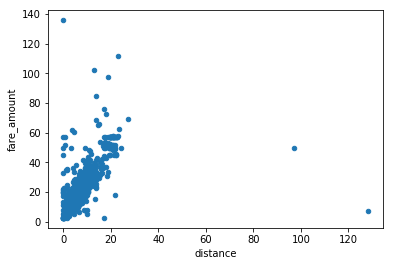

In [105]:
#Basis Analysis: Distribution of Passenger Count, distance pickup time to fare amount
dataset.plot.scatter(x="distance", y="fare_amount")

In [106]:
dataset[['passenger_count', 'fare_amount']].groupby('passenger_count').mean().reset_index()

,passenger_count,fare_amount
0,1,11.279469
1,2,11.820995
2,3,10.932118
3,4,13.087500
4,5,12.086203
5,6,10.016277


## Model Selection

In [118]:
def perform_kaggle_submission(filename, model):
    print("Performing on Kaggle Test")
    y_pred = model.predict(test_dataset_numpy)
    kaggle = keys
    fare_df = pd.DataFrame(data=y_pred, columns=['fare_amount'])
    kaggle['fare_amount'] = fare_df[['fare_amount']]
    kaggle.to_csv(filename, index=False)
    
    return kaggle

In [119]:
X=dataset.iloc[:,2:9]
y=dataset['fare_amount']

__Linear Regression__

In [120]:
model = Regression(X=X, y=y, model_type="linear_regression", normalize=True)
model.fit(model.X_train, model.y_train)
y_pred = model.predict(model.X_test)

train_result = model.validate_prediction(model.y_train, model.predict(model.X_train))
test_result = model.validate_prediction(model.y_test, y_pred)

print("Default Parameters Training_Set {}".format(train_result))
print("Default Parameters Test_Set {}".format(test_result))

result = perform_kaggle_submission("data/linear_regression_model.csv", model)

Default Parameters Training_Set mse = 51.01912162938214 & mae = 3.4893914622145608 & rmse = 7.142767084917591
Default Parameters Test_Set mse = 31.195618639704144 & mae = 3.213952241687233 & rmse = 5.585303809078262
Performing on Kaggle Test


/anaconda3/envs/ml-everything/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


__Stochastic Gradient Descent__

In [121]:
model = Regression(X=X, y=y, model_type="stochastic_gradient_descent", normalize=True)
model.fit(model.X_train, model.y_train)

y_pred = model.predict(model.X_test)
train_result = model.validate_prediction(model.y_train, model.predict(model.X_train))
test_result = model.validate_prediction(model.y_test, y_pred)

print("Training_Set {}".format(train_result))
print("Test_Set {}".format(test_result))

result = perform_kaggle_submission("data/sgd_model.csv", model)

Training_Set mse = 75.19916100897002 & mae = 5.001578327152657 & rmse = 8.671744980623567
Test_Set mse = 65.42025441956089 & mae = 4.854550151348979 & rmse = 8.088278829241787
Performing on Kaggle Test


/anaconda3/envs/ml-everything/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


__SVR__

In [ ]:
model = Regression(X=X, y=y, model_type="svr", normalize=True)
model.fit(model.X_train, model.y_train)

y_pred = model.predict(model.X_test)
train_result = model.validate_prediction(model.y_train, model.predict(model.X_train))
test_result = model.validate_prediction(model.y_test, y_pred)

print("Training_Set {}".format(train_result))
print("Test_Set {}".format(test_result))

grid_param = {
    "C": [1e0, 1e1, 1e2, 1e3], 
    "gamma": np.logspace(-2, 2, 5)}

model = Regression(X=X, y=y, model_type="svr", normalize=True)
best_parameters = model.perform_grid_search_cross_validation(model.X_train, model.y_train, grid_param, scoring=None)

model.update_with_parameters(best_parameters)
y_pred = model.predict(model.X_test)
train_result = model.validate_prediction(model.y_train, model.predict(model.X_train))
test_result = model.validate_prediction(model.y_test, y_pred)

print("Best Parameters Training_Set: {}".format(train_result))
print("Best Parameters Test_Set: {}".format(test_result))


result = perform_kaggle_submission("data/svr_model.csv", model)

Training_Set mse = 37.128493406794576 & mae = 2.6023862341407553 & rmse = 6.093315469167387
Test_Set mse = 32.03180733030998 & mae = 2.57193630050366 & rmse = 5.659664948591036


In [ ]:
print(best_parameters)

__Decision Tree Regression__

In [114]:
model = Regression(X=X, y=y, model_type="decision_tree", normalize=True)
model.fit(model.X_train, model.y_train)

y_pred = model.predict(model.X_test)
train_result = model.validate_prediction(model.y_train, model.predict(model.X_train))
test_result = model.validate_prediction(model.y_test, y_pred)

print("Training_Set {}".format(train_result))
print("Test_Set {}".format(test_result))


grid_param = {
    'max_depth' : [None, 3, 5, 10],
    "criterion": ["mse", "friedman_mse"]}

model = Regression(X=X, y=y, model_type="decision_tree", normalize=True)
best_parameters = model.perform_grid_search_cross_validation(model.X_train, model.y_train, grid_param, scoring=None)

model.update_with_parameters(best_parameters)
y_pred = model.predict(model.X_test)
train_result = model.validate_prediction(model.y_train, model.predict(model.X_train))
test_result = model.validate_prediction(model.y_test, y_pred)

print("Best Parameters Training_Set: {}".format(train_result))
print("Best Parameters Test_Set: {}".format(test_result))
print(best_parameters)


result = perform_kaggle_submission("kaggle_submissions/dtr_model.csv", model)

Training_Set mse = 1.5778675718805345e-31 & mae = 2.9376189417280564e-17 & rmse = 3.972238124635197e-16
Test_Set mse = 26.184446253229975 & mae = 2.89198105081826 & rmse = 5.117073993331538
Best Parameters Training_Set: mse = 1.5778675718805345e-31 & mae = 2.9376189417280564e-17 & rmse = 3.972238124635197e-16
Best Parameters Test_Set: mse = 28.249644272179154 & mae = 2.9971748492678727 & rmse = 5.315039442203525
{'criterion': 'friedman_mse', 'max_depth': 5}
Performing on Kaggle Test


/anaconda3/envs/ml-everything/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


__Ridge Regression__

In [115]:
model = Regression(X=X, y=y, model_type="ridge", normalize=True)
model.fit(model.X_train, model.y_train)

y_pred = model.predict(model.X_test)
train_result = model.validate_prediction(model.y_train, model.predict(model.X_train))
test_result = model.validate_prediction(model.y_test, y_pred)

print("Training_Set {}".format(train_result))
print("Test_Set {}".format(test_result))

grid_param = {
    "alpha": [1e0, 0.1, 1e-2, 1e-3], 
    "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

model = Regression(X=X, y=y, model_type="ridge", normalize=True)
best_parameters = model.perform_grid_search_cross_validation(model.X_train, model.y_train, grid_param, scoring=None)

model.update_with_parameters(best_parameters)
y_pred = model.predict(model.X_test)
train_result = model.validate_prediction(model.y_train, model.predict(model.X_train))
test_result = model.validate_prediction(model.y_test, y_pred)

print("Best Parameters Training_Set: {}".format(train_result))
print("Best Parameters Test_Set: {}".format(test_result))
print(best_parameters)

result = perform_kaggle_submission("kaggle_submissions/ridge_model.csv", model)

Training_Set mse = 51.01913349176767 & mae = 3.4900369476110233 & rmse = 7.142767915294999
Test_Set mse = 31.207155601140034 & mae = 3.2147132807948244 & rmse = 5.586336509837197
Best Parameters Training_Set: mse = 51.01913349176767 & mae = 3.4900369476110233 & rmse = 7.142767915294999
Best Parameters Test_Set: mse = 31.207155601140034 & mae = 3.2147132807948244 & rmse = 5.586336509837197
{'alpha': 1.0, 'solver': 'svd'}
Performing on Kaggle Test


/anaconda3/envs/ml-everything/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/anaconda3/envs/ml-everything/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


__LASSO__

In [116]:
model = Regression(X=X, y=y, model_type="lasso", normalize=True)
model.fit(model.X_train, model.y_train)

y_pred = model.predict(model.X_test)
train_result = model.validate_prediction(model.y_train, model.predict(model.X_train))
test_result = model.validate_prediction(model.y_test, y_pred)

print("Training_Set {}".format(train_result))
print("Test_Set {}".format(test_result))

grid_param = {
    "alpha": [1e0, 0.1, 1e-2, 1e-3]}

model = Regression(X=X, y=y, model_type="lasso", normalize=True)
best_parameters = model.perform_grid_search_cross_validation(model.X_train, model.y_train, grid_param, scoring=None)
best_parameters['positive'] = True

model.update_with_parameters(best_parameters)
y_pred = model.predict(model.X_test)
train_result = model.validate_prediction(model.y_train, model.predict(model.X_train))
test_result = model.validate_prediction(model.y_test, y_pred)

print("Best Parameters Training_Set: {}".format(train_result))
print("Best Parameters Test_Set: {}".format(test_result))
print(best_parameters)

result = perform_kaggle_submission("data/lasso_model.csv", model)

/anaconda3/envs/ml-everything/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Training_Set mse = 54.62464148275521 & mae = 3.784503226998413 & rmse = 7.390848495454037
Test_Set mse = 38.71925279001341 & mae = 3.600724077158814 & rmse = 6.222479633555533
Best Parameters Training_Set: mse = 54.62464148275521 & mae = 3.784503226998413 & rmse = 7.390848495454037
Best Parameters Test_Set: mse = 38.71925279001341 & mae = 3.600724077158814 & rmse = 6.222479633555533
{'alpha': 1.0, 'positive': True}
Performing on Kaggle Test


/anaconda3/envs/ml-everything/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


__Ensemble Methods__

__Gradient Boosting Regression__

RMSE: 3.6696


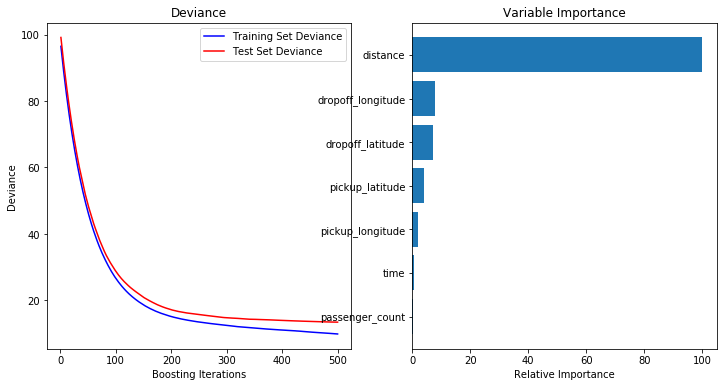

Performing on Kaggle Test


/anaconda3/envs/ml-everything/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
    
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}

clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X_train, y_train)

rmse = sqrt(mean_squared_error(y_test, clf.predict(X_test)))
print("RMSE: %.4f" % rmse)

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# Plot feature importance
feature_importance = clf.feature_importances_
feature_names = dataset.columns[2:9]
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


result = perform_kaggle_submission("data/gradient_boosting_model.csv", clf)